# 用户新增预测挑战赛Baseline
**赛题名称**：用户新增预测挑战赛
**赛题类型**：数据挖掘、二分类
**赛题链接**👇：
https://challenge.xfyun.cn/topic/info?type=subscriber-addition-prediction&ch=ymfk4uU

## 赛题背景
讯飞开放平台针对不同行业、不同场景提供相应的AI能力和解决方案，赋能开发者的产品和应用，帮助开发者通过AI解决相关实际问题，实现让产品能听会说、能看会认、能理解会思考。

用户新增预测是分析用户使用场景以及预测用户增长情况的关键步骤，有助于进行后续产品和应用的迭代升级。

## 赛事任务
本次大赛提供了讯飞开放平台海量的应用数据作为训练样本，参赛选手需要基于提供的样本构建模型，预测用户的新增情况。

## 赛题数据集
赛题数据由约62万条训练集、20万条测试集数据组成，共包含13个字段。

其中uuid为样本唯一标识，eid为访问行为ID，udmap为行为属性，其中的key1到key9表示不同的行为属性，如项目名、项目id等相关字段，common_ts为应用访问记录发生时间（毫秒时间戳），其余字段x1至x8为用户相关的属性，为匿名处理字段。target字段为预测目标，即是否为新增用户。

## 评价指标
本次竞赛的评价标准采用f1_score，分数越高，效果越好。

## 赛题思路
赛题是一个典型的数据挖掘的比赛，需要人工提取特征并构建模型，并且特征差异将会带来很大分数差异。

以下是基础版本的Baseline，详细内容将会在正式学习后开放，请大家耐心等候



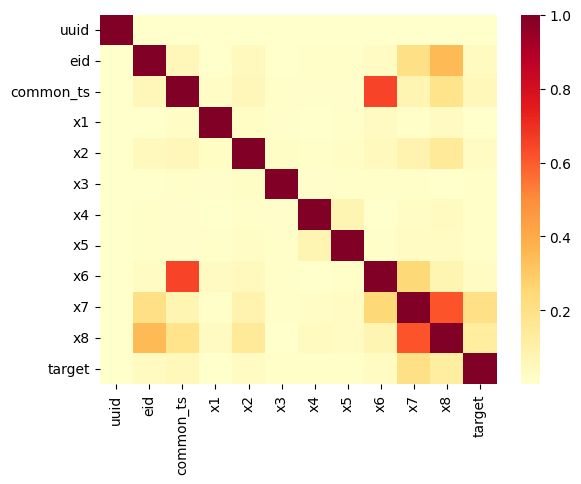

In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# 从 sklearn.tree 模块中导入 DecisionTreeClassifier 类
# DecisionTreeClassifier 用于构建决策树分类模型
from sklearn.tree import DecisionTreeClassifier

# 读取训练集文件
train_data = pd.read_csv('用户新增预测挑战赛公开数据/train.csv')
test_data = pd.read_csv('用户新增预测挑战赛公开数据/test.csv')

# 检查并转换所有能转为数值的列
for column in train_data.columns:
    try:
        train_data[column] = pd.to_numeric(train_data[column], errors='raise')
    except Exception:
        # 如果某列不能转为数值，则删除这列
        train_data.drop(column, axis=1, inplace=True)

# 创建相关性热力图
sns.heatmap(train_data.corr().abs(), cmap='YlOrRd')
plt.show()


In [19]:
train_data.head()

,eid,common_ts,x1,x2,x3,x4,x5,x6,x7,x8,target
uuid,,,,,,,,,,,
0,26,1689673468244,4,0,41,107,206,1,0,1,0
1,26,1689082941469,4,0,41,24,283,4,8,1,0
2,8,1689407393040,4,0,41,71,288,4,7,1,0
3,11,1689467815688,1,3,41,17,366,1,6,1,0
4,26,1689491751442,0,3,41,92,383,4,8,1,0


In [21]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 620356 entries, 0 to 620355
Data columns (total 12 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   uuid       620356 non-null  int64
 1   eid        620356 non-null  int64
 2   common_ts  620356 non-null  int64
 3   x1         620356 non-null  int64
 4   x2         620356 non-null  int64
 5   x3         620356 non-null  int64
 6   x4         620356 non-null  int64
 7   x5         620356 non-null  int64
 8   x6         620356 non-null  int64
 9   x7         620356 non-null  int64
 10  x8         620356 non-null  int64
 11  target     620356 non-null  int64
dtypes: int64(12)
memory usage: 56.8 MB


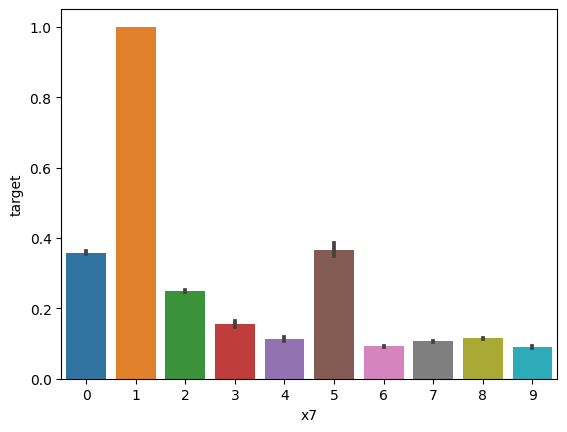

In [10]:
# x7分组下标签均值
sns.barplot(x='x7', y='target', data=train_data)

train_data['common_ts'] = pd.to_datetime(train_data['common_ts'], unit='ms')
test_data['common_ts'] = pd.to_datetime(test_data['common_ts'], unit='ms')

In [22]:
# 分析x1至x8的数据类型
data_types = train_data[['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8']].dtypes
numeric_fields = data_types[data_types != 'object'].index.tolist()
categorical_fields = data_types[data_types == 'object'].index.tolist()
print("数值类型的字段:", numeric_fields)
print("类别类型的字段:", categorical_fields)

数值类型的字段: ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8']
类别类型的字段: []


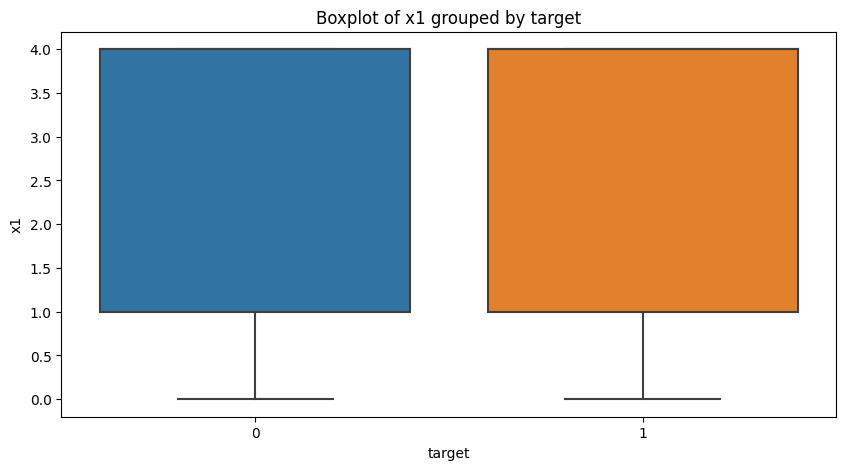

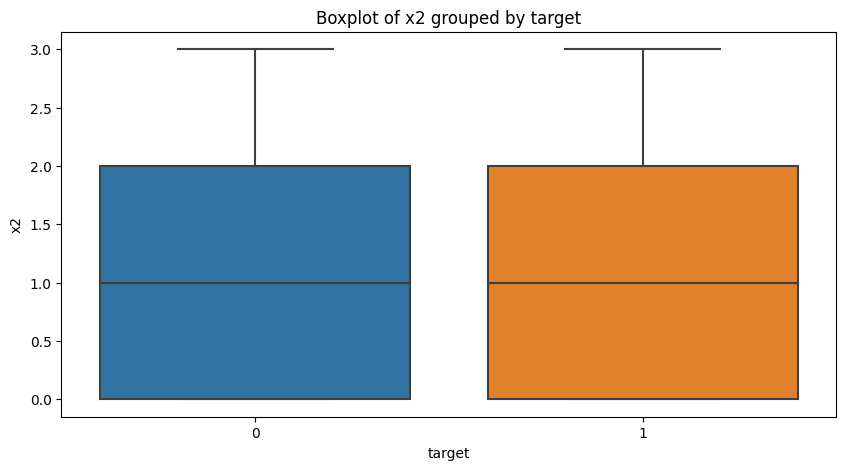

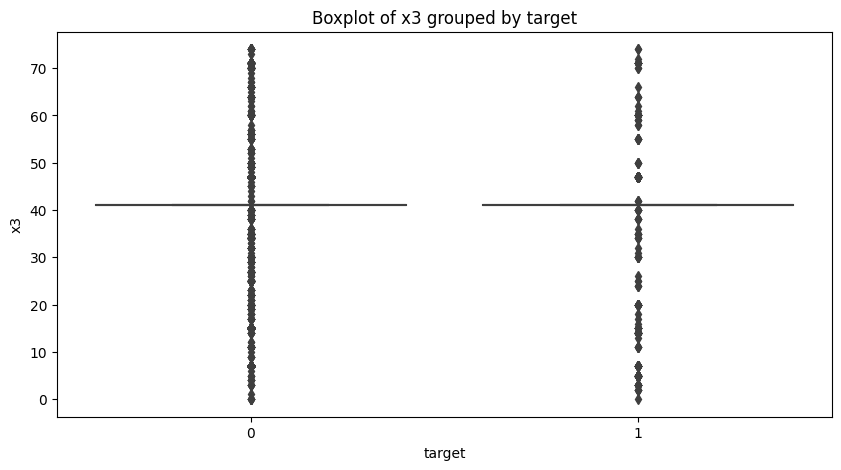

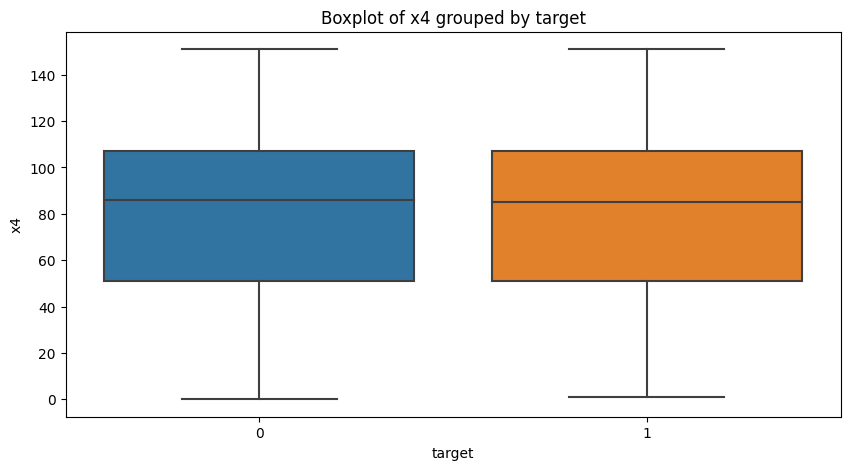

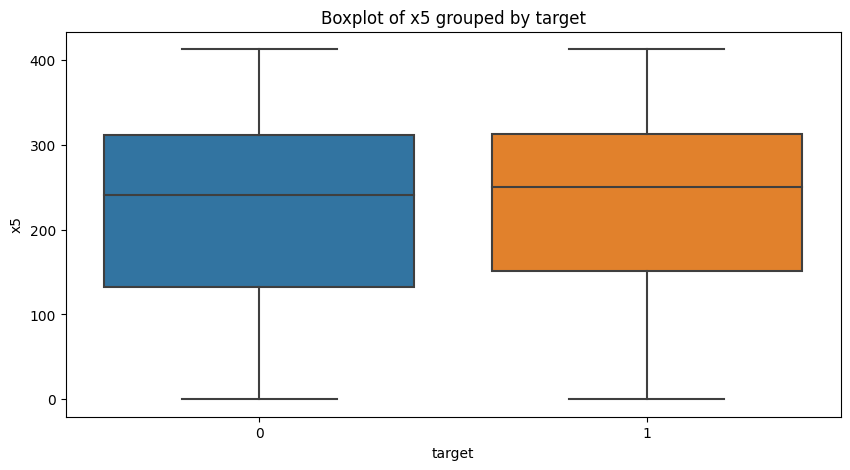

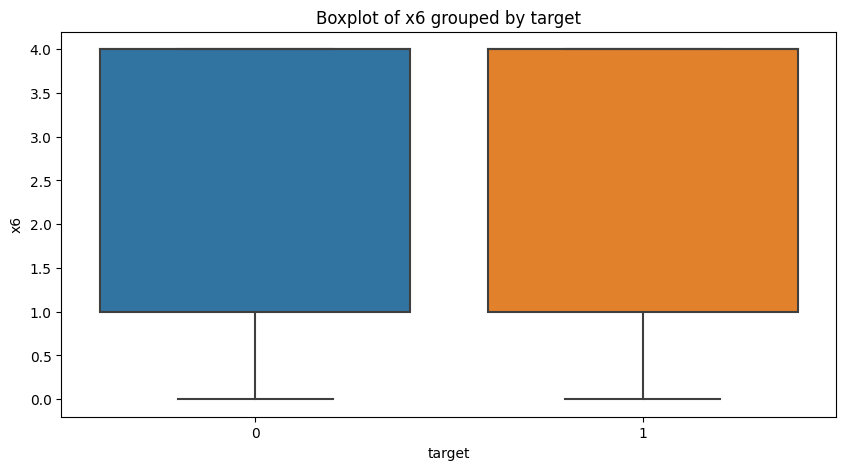

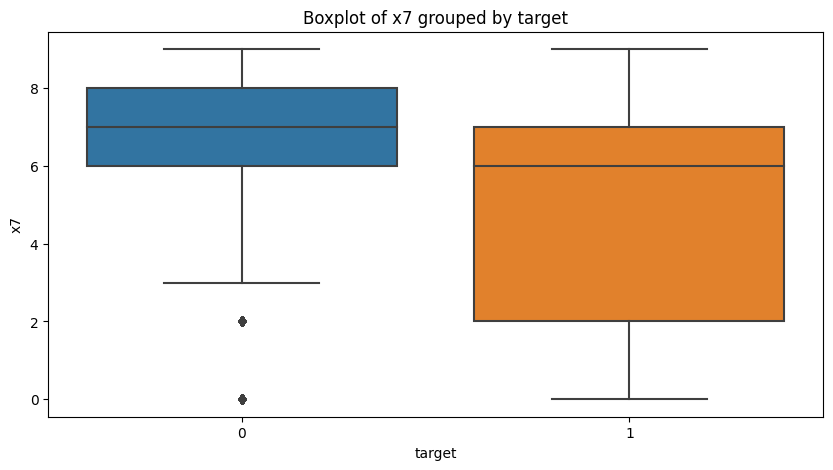

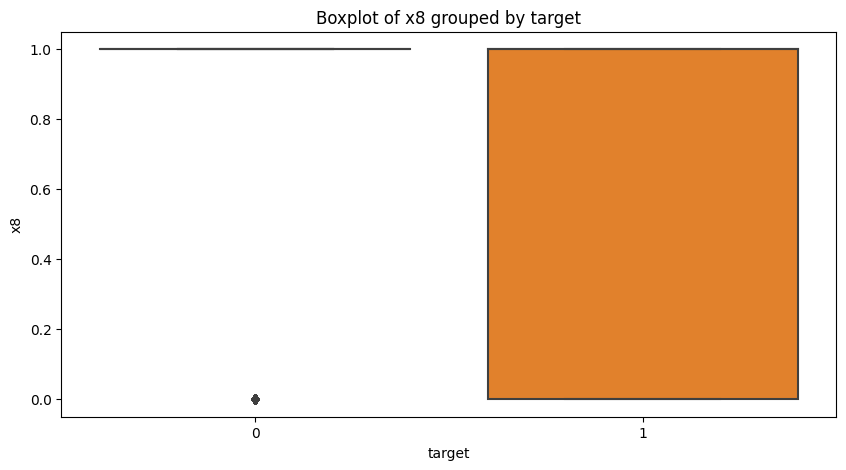

In [23]:
# 绘制数值类型字段的箱线图
for field in numeric_fields:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x='target', y=field, data=train_data)
    plt.title(f'Boxplot of {field} grouped by target')
    plt.show()

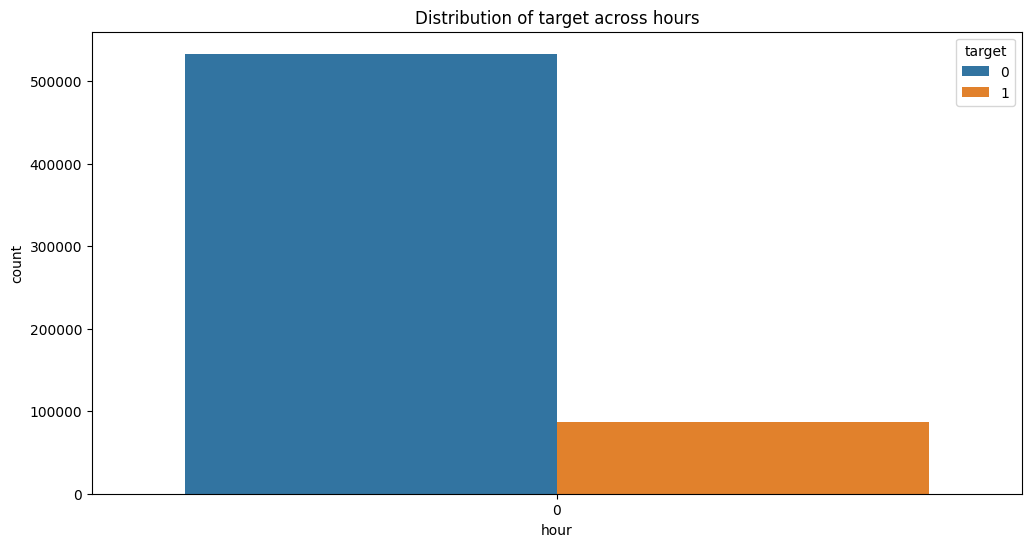

In [25]:
# 从common_ts中提取小时
train_data['hour'] = pd.to_datetime(train_data['common_ts']).dt.hour

# 绘制每小时下的标签分布
plt.figure(figsize=(12, 6))
sns.countplot(x='hour', hue='target', data=train_data)
plt.title('Distribution of target across hours')
plt.show()


In [26]:
def udmap_onethot(d):
    v = np.zeros(9)
    if d == 'unknown':
        return v
    
    d = eval(d)
    for i in range(1, 10):
        if 'key' + str(i) in d:
            v[i-1] = d['key' + str(i)]
            
    return v

train_udmap_df = pd.DataFrame(np.vstack(train_data['udmap'].apply(udmap_onethot)))
test_udmap_df = pd.DataFrame(np.vstack(test_data['udmap'].apply(udmap_onethot)))

train_udmap_df.columns = ['key' + str(i) for i in range(1, 10)]
test_udmap_df.columns = ['key' + str(i) for i in range(1, 10)]

train_data = pd.concat([train_data, train_udmap_df], axis=1)
test_data = pd.concat([test_data, test_udmap_df], axis=1)

# 计算每个key对应的标签均值
key_means = train_data[[f'key{i}' for i in range(1, 10)]].multiply(train_data['target'], axis=0).mean()

# 绘制直方图
key_means.sort_values().plot(kind='bar', figsize=(12, 6))
plt.title('Average target value for each key in udmap')
plt.ylabel('Average target value')
plt.show()


KeyError: 'udmap'

## 任务2.2：模型交叉验证

In [8]:
# 导入库
import pandas as pd
import numpy as np

# 读取训练集和测试集文件
train_data = pd.read_csv('用户新增预测挑战赛公开数据/train.csv')
test_data = pd.read_csv('用户新增预测挑战赛公开数据/test.csv')

# 提取udmap特征，人工进行onehot
def udmap_onethot(d):
    v = np.zeros(9)
    if d == 'unknown':
        return v
    d = eval(d)
    for i in range(1, 10):
        if 'key' + str(i) in d:
            v[i-1] = d['key' + str(i)]
            
    return v
train_udmap_df = pd.DataFrame(np.vstack(train_data['udmap'].apply(udmap_onethot)))
test_udmap_df = pd.DataFrame(np.vstack(test_data['udmap'].apply(udmap_onethot)))
train_udmap_df.columns = ['key' + str(i) for i in range(1, 10)]
test_udmap_df.columns = ['key' + str(i) for i in range(1, 10)]

# 编码udmap是否为空
train_data['udmap_isunknown'] = (train_data['udmap'] == 'unknown').astype(int)
test_data['udmap_isunknown'] = (test_data['udmap'] == 'unknown').astype(int)

# udmap特征和原始数据拼接
train_data = pd.concat([train_data, train_udmap_df], axis=1)
test_data = pd.concat([test_data, test_udmap_df], axis=1)

# 提取eid的频次特征
train_data['eid_freq'] = train_data['eid'].map(train_data['eid'].value_counts())
test_data['eid_freq'] = test_data['eid'].map(train_data['eid'].value_counts())

# 提取eid的标签特征
train_data['eid_mean'] = train_data['eid'].map(train_data.groupby('eid')['target'].mean())
test_data['eid_mean'] = test_data['eid'].map(train_data.groupby('eid')['target'].mean())

# 提取时间戳
train_data['common_ts'] = pd.to_datetime(train_data['common_ts'], unit='ms')
test_data['common_ts'] = pd.to_datetime(test_data['common_ts'], unit='ms')
train_data['common_ts_hour'] = train_data['common_ts'].dt.hour
test_data['common_ts_hour'] = test_data['common_ts'].dt.hour

# 导入模型
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

# 导入交叉验证和评价指标
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report

# 训练并验证SGDClassifier
pred = cross_val_predict(
    SGDClassifier(max_iter=10),
    train_data.drop(['udmap', 'common_ts', 'uuid', 'target'], axis=1),
    train_data['target']
)
print(classification_report(train_data['target'], pred, digits=3))

# 训练并验证DecisionTreeClassifier
pred = cross_val_predict(
    DecisionTreeClassifier(),
    train_data.drop(['udmap', 'common_ts', 'uuid', 'target'], axis=1),
    train_data['target']
)
print(classification_report(train_data['target'], pred, digits=3))

# 训练并验证MultinomialNB
pred = cross_val_predict(
    MultinomialNB(),
    train_data.drop(['udmap', 'common_ts', 'uuid', 'target'], axis=1),
    train_data['target']
)
print(classification_report(train_data['target'], pred, digits=3))

# 训练并验证RandomForestClassifier
pred = cross_val_predict(
    RandomForestClassifier(n_estimators=5),
    train_data.drop(['udmap', 'common_ts', 'uuid', 'target'], axis=1),
    train_data['target']
)
print(classification_report(train_data['target'], pred, digits=3))

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increa

              precision    recall  f1-score   support

           0      0.864     0.973     0.915    533155
           1      0.281     0.064     0.104     87201

    accuracy                          0.845    620356
   macro avg      0.573     0.519     0.510    620356
weighted avg      0.782     0.845     0.801    620356

              precision    recall  f1-score   support

           0      0.934     0.940     0.937    533155
           1      0.617     0.593     0.605     87201

    accuracy                          0.891    620356
   macro avg      0.776     0.766     0.771    620356
weighted avg      0.889     0.891     0.890    620356

              precision    recall  f1-score   support

           0      0.893     0.736     0.807    533155
           1      0.221     0.458     0.298     87201

    accuracy                          0.697    620356
   macro avg      0.557     0.597     0.552    620356
weighted avg      0.798     0.697     0.735    620356

              preci

In [10]:
# 对于模型效果的比较：
from sklearn.metrics import f1_score

models = {
    "SGDClassifier": SGDClassifier(max_iter=10),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "MultinomialNB": MultinomialNB(),
    "RandomForestClassifier": RandomForestClassifier(n_estimators=5)
}

f1_scores = {}
X = train_data.drop(['udmap', 'common_ts', 'uuid', 'target'], axis=1)
y = train_data['target']

for name, model in models.items():
    pred = cross_val_predict(model, X, y)
    f1_scores[name] = f1_score(y, pred, average='macro')

best_model = max(f1_scores, key=f1_scores.get)
print(f"The model with the highest macro F1 score is {best_model} with a score of {f1_scores[best_model]:.3f}.")


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increa

The model with the highest macro F1 score is DecisionTreeClassifier with a score of 0.771.



决策树模型在某些数据集上可能表现得比其他模型更好，原因可能有以下几点：

- 模型复杂性: 决策树是一个非参数模型，这意味着它没有预设的形式。这使得决策树能够自由地拟合数据，特别是当数据有复杂的非线性模式时。

- 特征交互: 决策树能够自然地捕捉特征之间的交互。如果某些特征组合对目标变量有很强的预测能力，决策树可以很容易地利用这一点。

- 处理不平衡数据: 如果数据集是不平衡的（例如，一个类别的样本数远远大于另一个类别），决策树可以通过调整分裂的标准来处理这种不平衡。

- 特征的本质: 在某些数据集上，某些特征可能会有明显的“分裂点”，这些点可以很好地区分不同的目标类别。决策树通过选择这些分裂点来制定决策。

- 不需要特征缩放: 与需要特征缩放的模型（如SVM或KNN）不同，决策树不需要特征缩放就可以正常工作。

- 容错性: 决策树对于某些类型的数据噪声和异常值具有容错性。

- 数据的特性: 最后但同样重要的是，您的数据可能具有某种结构，该结构与决策树的工作方式特别匹配。

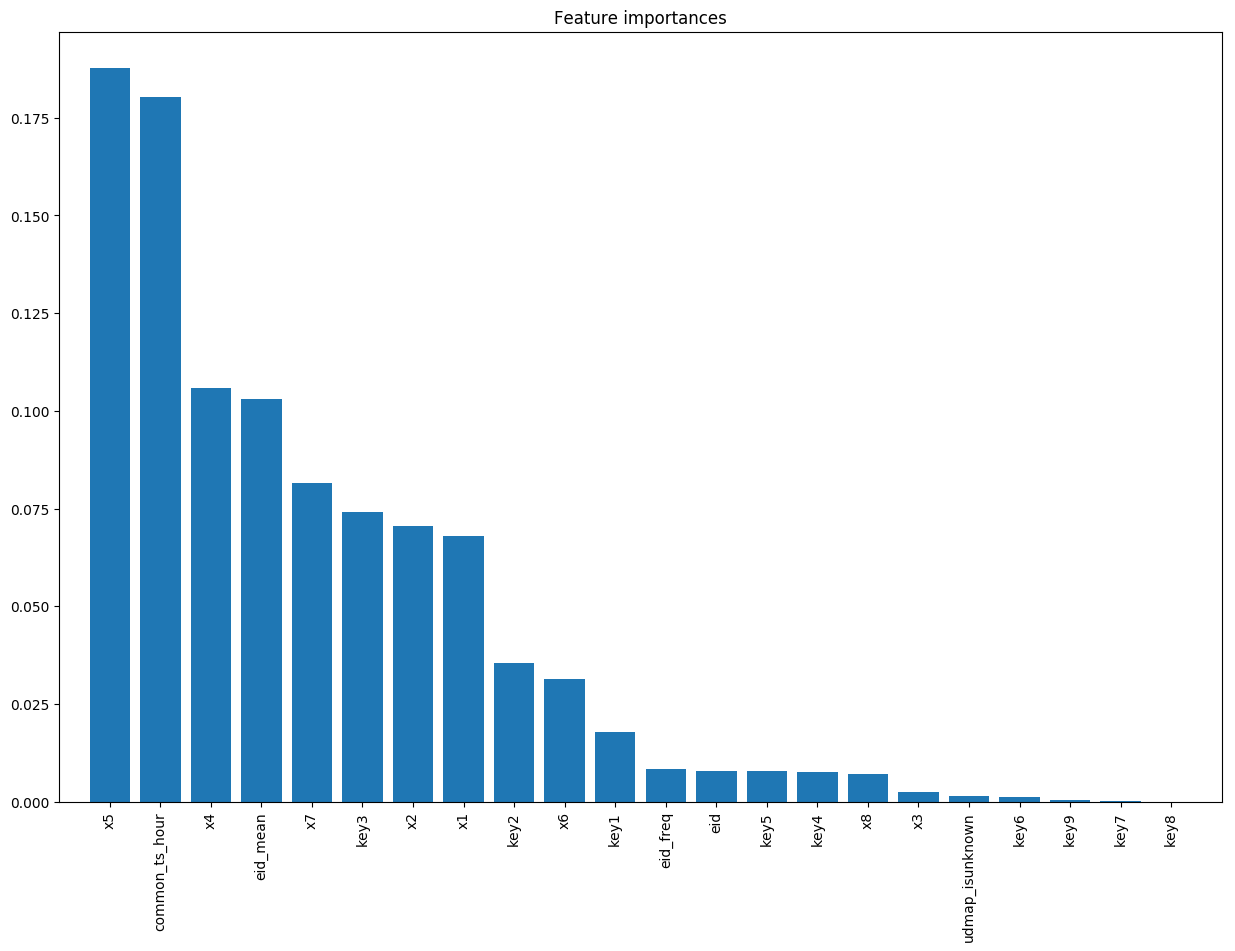

In [11]:
# 树模型特征重要性的可视化：

model = DecisionTreeClassifier()
model.fit(X, y)

# Plotting feature importance
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(15,10))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

In [ ]:
# 添加另外三个模型并对比它们的精度：
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

# 对SVC进行交叉验证
pred = cross_val_predict(SVC(), X, y)
f1_scores["SVC"] = f1_score(y, pred, average='macro')
print(f"SVC: {f1_scores['SVC']:.3f}")

In [ ]:
# 对GradientBoostingClassifier进行交叉验证
pred = cross_val_predict(GradientBoostingClassifier(), X, y)
f1_scores["GradientBoostingClassifier"] = f1_score(y, pred, average='macro')
print(f"GradientBoostingClassifier: {f1_scores['GradientBoostingClassifier']:.3f}")

In [ ]:
# 对KNeighborsClassifier进行交叉验证
pred = cross_val_predict(KNeighborsClassifier(), X, y)
f1_scores["KNeighborsClassifier"] = f1_score(y, pred, average='macro')
print(f"KNeighborsClassifier: {f1_scores['KNeighborsClassifier']:.3f}")

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# 1. 使用随机森林模型进行训练
clf_rf = RandomForestClassifier(n_estimators=100, random_state=42)
clf_rf.fit(train_data.drop(['udmap', 'common_ts', 'uuid', 'target'], axis=1), train_data['target'])

# 2. 对测试集进行预测
result_df_rf = pd.DataFrame({
    'uuid': test_data['uuid'],
    'target': clf_rf.predict(test_data.drop(['udmap', 'common_ts', 'uuid'], axis=1))
})

# 3. 保存随机森林的预测结果
result_df_rf.to_csv('submit_rf.csv', index=None)

# 提示：上述代码使用了随机森林模型，它是一个集成模型，由多棵决策树组成。
# 通过结合多棵树的预测，随机森林可以提高预测的准确性，并且还能提供特征的重要性评分。


In [ ]:
# 导入库
import pandas as pd
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import f1_score

# 读取训练集和测试集文件
# 注意：这里使用的路径是假设的，请根据实际文件路径进行修改
train_data = pd.read_csv('用户新增预测挑战赛公开数据/train.csv')
test_data = pd.read_csv('用户新增预测挑战赛公开数据/test.csv')

# 将时间戳转换为datetime对象，以便提取新特征
train_data['common_ts'] = pd.to_datetime(train_data['common_ts'], unit='ms')
test_data['common_ts'] = pd.to_datetime(test_data['common_ts'], unit='ms')

# 添加额外的特征
train_data['x5_freq'] = train_data['x5'].map(train_data['x5'].value_counts())
test_data['x5_freq'] = test_data['x5'].map(train_data['x5'].value_counts())
train_data['common_ts_weekday'] = train_data['common_ts'].dt.weekday
test_data['common_ts_weekday'] = test_data['common_ts'].dt.weekday
train_data['common_ts_is_weekend'] = train_data['common_ts_weekday'].isin([5, 6]).astype(int)
test_data['common_ts_is_weekend'] = test_data['common_ts_weekday'].isin([5, 6]).astype(int)

# 重新定义模型字典以包括新模型
all_models = {
    "SGDClassifier": SGDClassifier(max_iter=10),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "MultinomialNB": MultinomialNB(),
    "RandomForestClassifier": RandomForestClassifier(n_estimators=5),
    "SVC": SVC(),
    "GradientBoostingClassifier": GradientBoostingClassifier(),
    "KNeighborsClassifier": KNeighborsClassifier()
}

new_f1_scores = {}
y = train_data['target']
for name, model in all_models.items():
    pred = cross_val_predict(model, train_data.drop(['udmap', 'common_ts', 'uuid', 'target'], axis=1), y)
    new_f1_scores[name] = f1_score(y, pred, average='macro')

new_f1_scores